# 1. Imports

In [1]:
import numpy as np
from math import pi

from matplotlib import pyplot as plt

import seaborn as sn
import pandas as pd

In [2]:
from tensorflow.keras.models import load_model

In [3]:
from tensorflow.keras.losses import MSE
from tensorflow.keras.losses import categorical_crossentropy as CCE
import tensorflow as tf

In [4]:
from art.attacks.evasion import *
from art.estimators.classification import TensorFlowV2Classifier

import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
# Load properties from another python file
from properties import *

In [6]:
from random import random, randint

# 2. Load models

In [7]:
path_model = "ACAS_XU_tf_keras/ACASXU_1_1.h5"

In [8]:
model_11 = load_model(path_model)

In [ ]:
model_35 = load_model("ACAS_XU_tf_keras/ACASXU_3_5.h5")

In [9]:
model_11.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 50)                300       
_________________________________________________________________
activation_98 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_99 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 50)                2550      
_________________________________________________________________
activation_100 (Activation)  (None, 50)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 50)              

In [10]:
model_11.compile()

In [ ]:
model_35.compile()

In [ ]:
pt = np.array([1.0, 1.0, 1.0, 1.0, 1.0]).reshape(1,5)
model_11.predict(pt)

In [ ]:
pt = np.array([1.0, 1.0, 1.0, 1.0, 1.0]).reshape(1,5)
model_35.predict(pt)

In [29]:
ACAS_model = model_11

# 3. Carlini & Wagner = CW

In [ ]:
"""
def generate_adv_sample(model, x0, label, loss_function="MSE", eps=1e-5):
    # transforming into a tensorflow object
    x0_ = tf.cast(x0, tf.float32)
    
    # record our gradients
    with tf.GradientTape() as tape:
        # explicitly indicate that our input should be tacked for gradient updates
        tape.watch(x0_)

        # use our model to make predictions on the input and then compute the loss
        pred = model(x0_)
        if loss_function == "CCE":
            np_label = np.array([i==label for i in range(0,5)]).reshape((1,5))
            loss = CCE(np_label, pred)
        elif loss_function == "MSE":
            loss = MSE(label, pred)
        else:
            raise Exception("Unknown loss function '{0}'".format(loss_function))
        
        # calculate the gradients of loss with respect to the input, then compute the sign of the gradient
        gradient = tape.gradient(loss, x0_)
        signedGrad = tf.sign(gradient)

        # construct the image adversary
        adv_sample = (x0_ + (signedGrad * eps)).numpy()

        # return the adversarial sample to the calling function
        return(adv_sample)
"""

In [13]:
x_test = 0.8*np.array([[1.0, 1.0, 1.0, 1.0, 1.0],[0.6, 0.5, 1.0, 0.3, 1.0]])
print(x_test.shape)
print(x_test)

(2, 5)
[[0.8  0.8  0.8  0.8  0.8 ]
 [0.48 0.4  0.8  0.24 0.8 ]]


In [30]:
ACAS_classifier = TensorFlowV2Classifier(
    model=ACAS_model,
    loss_object=MSE,
    train_step=None,
    nb_classes=5,
    input_shape=(1, 5, 1),
    clip_values=(-1.0, 1.0),
)

In [14]:
attack_CW = CarliniLInfMethod(classifier=ACAS_classifier,
                              initial_const=1.0, 
                              max_iter=100, 
                              # targeted=True, 
                              verbose=True)

x_adv_cw = attack_CW.generate(x_test) #, y=np.array([[0,1,0,0,0]]))

print(x_adv_cw.shape)
print(x_adv_cw)


(2, 5)
[[0.8  0.8  0.8  0.8  0.8 ]
 [0.48 0.4  0.8  0.24 0.8 ]]


In [39]:
intensity_fgsm = 0.8

attack_FGSM = FastGradientMethod(estimator=ACAS_classifier,
                                 eps=intensity_fgsm)

x_adv_fgsm = attack_FGSM.generate(x_test)

print(x_adv_fgsm)

[[ 0.    0.    1.    0.    1.  ]
 [-0.32 -0.4   1.    1.    0.  ]]


# 4. Generate points

In [103]:
def random_pts(n, prop_dom, main_dom):
    """ prop_dom is a list of domains given by intervals in a numpy 2x5 table. """
    ndom = len(prop_dom)
    ndim = main_dom.shape[1]
    
    x = np.zeros((n,ndim))
    for i in range(n): # generate the i-th point
        choosen_dom = prop_dom[randint(0,ndom-1)] # choose the input property domain for a given prop
        for k in range(ndim): # create a random coord for each dim
            boundaries = main_dom[:,k]
            if choosen_dom[0,k] != None:
                boundaries[0] = choosen_dom[0,k]
            if choosen_dom[1,k] != None:
                boundaries[1] = choosen_dom[1,k]
            x[i,k] = boundaries[0] + random()*(boundaries[1]-boundaries[0])

    return(x)

In [16]:
def random_main_pts(n, main_dom):
    """ Generate random points in the main domain given by intervals stored in a numpy 2x5 table. """
    ndim = main_dom.shape[1]
    
    x = np.zeros((n,ndim))
    for k in range(ndim): # create a random coord for each dim
        col = main_dom[0,k]*np.ones((n,1)) + np.random.rand(n,1)*(main_dom[1,k] - main_dom[0,k])
        for i in range(n):
            x[i,k] = col[i]

    return(x)

In [79]:
x_test = random_main_pts(1000, X_dom)

In [104]:
def normalize(x, x_mean, x_range):
    (n,k) = x.shape
    nx = np.zeros((n,k))
    for i in range(n):
        for j in range(k):
            nx[i,j] = (x[i,j]-x_mean[j])/x_range[j]
    return(nx)

In [105]:
def check_pts(model, input_pts, IP, OP):
    n = input_pts.shape[0]
    IO_check = np.zeros((n,2)) # 1st column : input checked - 2nd column : output checked
    
    norm_input = normalize(input_pts, X_mean, X_range) # normalize pts
    
    pred_pts = model.predict(norm_input) # make predictions with the model (neural net)
    
    for k in range(n):
        IO_check[k,0] = IP(input_pts[k,:]) # check input (just in case)
        IO_check[k,1] = OP(pred_pts[k,:]) # check output

    return(IO_check, pred_pts)

In [112]:
rand_inputs = random_pts(1000000, IP2_dom, X_dom)

In [113]:
Pcheck, pred_pts = check_pts(model_11, rand_inputs, IP1, OP1)

In [117]:
def find_adverse(input_pts, prop_check):
    n = prop_check.shape[0]
    index = []
    for k in range(n):
        if prop_check[k,0] and not(prop_check[k,1]):
            index.append(k)
    return(input_pts[index,:])

In [118]:
adv = find_adverse(rand_inputs, Pcheck)
print(adv.shape)

(0, 5)


In [116]:
Pcheck.shape

(1000000, 2)

# 5. Attack the networks : FGSM & CW

### Define the attacks

In [ ]:
# Classifier object <~> neural network ACAS-Xu ...

ACAS_classifier = TensorFlowV2Classifier(model = ACAS_model,
                                         loss_object = MSE, # MSE or CCE ?...
                                         train_step = None,
                                         nb_classes = 5,
                                         input_shape = (1, 5, 1),
                                         clip_values = (-1.0, 1.0))

In [ ]:
# x_test = 0.8*np.array([ [1.0, 1.0, 1.0, 1.0, 1.0],
#                         [0.6, 0.5, 1.0, 0.3, 1.0] ])

Carlini-Wagner (CW) attack

In [ ]:
attack_CW = CarliniLInfMethod(classifier=ACAS_classifier,
                              initial_const = 1.0, 
                              max_iter = 100, 
                              # targeted=True, 
                              verbose = True)

# x_adv_cw = attack_CW.generate(x_test) #, y=np.array([[0,1,0,0,0]]))
# print(x_adv_cw)

Fast Gradient Sign Method (FGSM) attack

In [ ]:
intensity_fgsm = 0.8

attack_FGSM = FastGradientMethod(estimator = ACAS_classifier,
                                 eps = intensity_fgsm,
                                 verbose = True)

# x_adv_fgsm = attack_FGSM.generate(x_test)
# print(x_adv_fgsm)

### Create random (normalized) points

In [57]:
original_pts = np.random.rand(1000, 5) # random_main_pts(10, X_dom)

In [58]:
print(original_pts)

[[0.354986   0.43409574 0.67401931 0.50359911 0.64050917]
 [0.46228356 0.35473085 0.24254728 0.90418688 0.12074055]
 [0.47477681 0.52769778 0.21174329 0.80267184 0.71568684]
 ...
 [0.34751314 0.36367209 0.8139905  0.83486859 0.04938584]
 [0.6452491  0.89393246 0.9448012  0.47352179 0.48399115]
 [0.76520923 0.09770033 0.43425142 0.48849708 0.85417129]]


In [60]:
adv_pts_cw = attack_CW.generate(original_pts)

In [59]:
adv_pts_fgsm = attack_FGSM.generate(original_pts)

In [114]:
print("CW adv points")
print(adv_pts_cw,"\n")

print("FGSM adv points")
print(adv_pts_fgsm)

CW adv points
[[0.354986   0.43409574 0.67401934 0.5035991  0.6405092 ]
 [0.46228355 0.35473084 0.24254727 0.9041869  0.12074055]
 [0.4747768  0.5276978  0.21174328 0.80267185 0.71568686]
 ...
 [0.34751314 0.36367208 0.8139905  0.8348686  0.04938584]
 [0.6452491  0.89393246 0.9448012  0.4735218  0.48399115]
 [0.76520926 0.09770034 0.43425143 0.48849708 0.8541713 ]] 

FGSM adv points
[[ 1.         -0.36590427 -0.12598068  1.         -0.15949082]
 [-0.33771643 -0.44526914 -0.55745274  0.10418689  0.92074054]
 [-0.32522318 -0.2723022   1.          1.         -0.08431315]
 ...
 [-0.45248687 -0.4363279   1.          0.0348686   0.84938586]
 [ 1.          0.09393246  1.         -0.3264782  -0.31600887]
 [-0.03479075 -0.70229965 -0.36574858 -0.31150293  0.05417129]]


In [62]:
# Make predictions with the adversarial points

original_pred = ACAS_model.predict(original_pts)
adv_pred_cw = ACAS_model.predict(adv_pts_cw)
adv_pred_fgsm = ACAS_model.predict(adv_pts_fgsm)

print("Original pred :")
print(original_pred,"\n")

print("CW pred :")
print(adv_pred_cw,"\n")

print("FGSM pred :")
print(adv_pred_fgsm)

In [64]:
# Get advices from the predictions of the network (prediction = min score)

original_advice = np.argmin(original_pred, axis=1)
cw_advice = np.argmin(adv_pred_cw, axis=1)
fgsm_advice = np.argmin(adv_pred_fgsm, axis=1)

"""
print(original_advice)
print(cw_advice)
print(fgsm_advice)
"""

### Results visualization with confusion matrix

In [71]:
def confusion_matrix(pred0, pred1, n_classes=5):
    """ Create the n_classes*n_classes confusion matrix of pred1 compared to the original pred0. 
        - cmat[i,j] = nb of pts classified as i at the origin and as j after the attack """
    cmat = np.zeros((n_classes,n_classes)).astype(int)
    n_sample = pred0.shape[0]
    for k in range(n_sample):
        cmat[pred0[k],pred1[k]] += 1
    return(cmat)

In [91]:
def norm_rows(cmat):
    """ Normalize the lines of the confusion matrix cmat. """
    n = cmat.shape[0]
    ncmat = np.zeros((n,n))
    sum_rows = np.sum(cmat_cw, axis=1)
    for k in range(n):
        s = sum_rows[k]
        if s != 0:
            ncmat[k,:] = cmat[k,:]/sum_rows[k]
    return(ncmat)

In [109]:
# confusion matrix
cmat_cw = confusion_matrix(original_advice, cw_advice)
print(cmat_cw)

# confusion matrix with normalized lines
ncmat_cw = norm_rows(cmat_cw)
print(ncmat_cw)

[[915   0   0   1   0]
 [  0   0   0   0   0]
 [  2   0  33   1   1]
 [  4   0   3  10   0]
 [  0   0   3   2  25]]
[[0.9989083  0.         0.         0.0010917  0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.05405405 0.         0.89189189 0.02702703 0.02702703]
 [0.23529412 0.         0.17647059 0.58823529 0.        ]
 [0.         0.         0.1        0.06666667 0.83333333]]


In [110]:
# confusion matrix
cmat_fgsm = confusion_matrix(original_advice, fgsm_advice)
print(cmat_fgsm)

# confusion matrix with normalized lines
ncmat_fgsm = norm_rows(cmat_fgsm)
print(ncmat_fgsm)

[[518  75  30  81 212]
 [  0   0   0   0   0]
 [ 27   4   0   0   6]
 [ 10   3   0   1   3]
 [ 23   2   1   1   3]]
[[0.56550218 0.08187773 0.03275109 0.08842795 0.23144105]
 [0.         0.         0.         0.         0.        ]
 [0.72972973 0.10810811 0.         0.         0.16216216]
 [0.58823529 0.17647059 0.         0.05882353 0.17647059]
 [0.76666667 0.06666667 0.03333333 0.03333333 0.1       ]]


In [102]:
# confusion matrix plot legend
index0 = ["COC","WR","WL","SR","SL"]
index1 = ["adv-COC","adv-WR","adv-WL","adv-SR","adv-SL"]

### Plot confusion matrix for CW attack

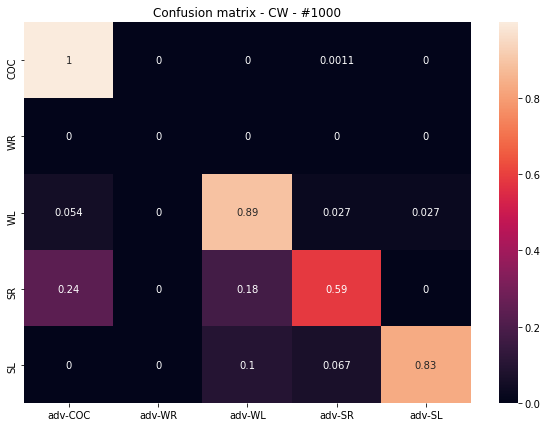

In [108]:
df_cmat = pd.DataFrame(ncmat_cw, index = index0, columns = index1)

plt.figure(figsize = (10,7))
sn.heatmap(df_cmat, annot=True)
plt.title("Confusion matrix - CW - #{0}".format(1000))
plt.show()

### Plot confusion matrix for FGSM attack

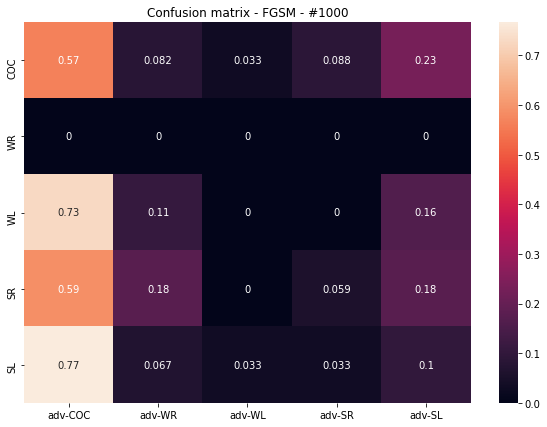

In [107]:
df_cmat = pd.DataFrame(ncmat_fgsm, index = index0, columns = index1)

plt.figure(figsize = (10,7))
sn.heatmap(df_cmat, annot=True)
plt.title("Confusion matrix - FGSM - #{0}".format(1000))
plt.show()